In [1]:
import os
import copy
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
%matplotlib inline
from transformers import AutoTokenizer, AutoModelWithLMHead
import shap
from shap.utils import GenerateLogits
import scipy as sp
import nlp
import torch
import spacy
from shap.utils import assert_import, record_import_error, safe_isinstance, make_masks, OpChain, MaskedModel
from shap import maskers, links

In [2]:
dataset = nlp.load_dataset('xsum',split='train')

WARNING - Using custom data configuration default


In [3]:
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-xsum-12-6")
model =  AutoModelWithLMHead.from_pretrained("sshleifer/distilbart-xsum-12-6").cuda()

The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.


In [4]:
# Instantiate object of GenerateLogits with model and tokenizer
logit_generator_model = GenerateLogits(model=model,tokenizer=tokenizer)

In [5]:
def f_predict(x):
    model.eval()
    input_ids = torch.tensor([tokenizer.encode(x)]).cuda()
    with torch.no_grad():
        out=model.generate(input_ids)
    sentence = [tokenizer.decode(g, skip_special_tokens=True) for g in out][0]
    del input_ids, out
    return sentence

In [6]:
def gen_kwargs(x):
    model.eval()
    input_ids = torch.tensor([tokenizer.encode(x)]).cuda()
    with torch.no_grad():
        # generate input ids for output translation which we aim to explain
        out=model.generate(input_ids)
    # slice sentence by removing bos and eos token ids
    target_sentence_ids = out[:,1:-1].cuda()
    output_names = logit_generator_model.get_output_names(target_sentence_ids)
    del out
    return {'target_sentence_ids':target_sentence_ids,'input_ids':input_ids,'output_names':output_names,'fixed_context':0}

In [7]:
# This function defines the additional arguments passed onto the model function required inorder to get conditional logits corresponding to the original input sentence translation
def f_kwargs(x):
    kwargs = gen_kwargs(x)
    return kwargs

In [8]:
def plot_logits(token_ids,sentence_ids,conditional_logits,sentences,batch_args,output_batch,i,fixed_context,clust_matrix,M):
    m00, m10, m01, f00, f11, ind, lind, rind, weight = batch_args[i//2]
    f10, f01 = output_batch[i-1], output_batch[i]
    f10_summary = f_predict(sentences[i-1])
    f01_summary = f_predict(sentences[i])
    f10_highlight_mask, f01_highlight_mask = m10 ^ m00, m01 ^ m00
    f10_highlight = tokenizer.decode(sentence_ids[0,1:-1][f10_highlight_mask[1:-1]])
    f01_highlight = tokenizer.decode(sentence_ids[0,1:-1][f01_highlight_mask[1:-1]])
    f10_highlight_in_context = sentences[i-1].replace(f10_highlight,"\033[1m"+f10_highlight+"\033[0m")
    f01_highlight_in_context = sentences[i].replace(f01_highlight,"\033[1m"+f01_highlight+"\033[0m")
    print(f'\n \033[1mMasked input (f10):\033[0m {f10_highlight_in_context}')
    print(f'\n \033[1mSummary (f10):\033[0m {f10_summary}')
    print(f'\n \033[1mMasked input (f01):\033[0m {f01_highlight_in_context}')
    print(f'\n \033[1mSummary (f01):\033[0m {f01_summary}')
    interaction_effect = (f11 - f10 - f01 + f00) if fixed_context==0 else -(f11 - f10 - f01 + f00)
    main_effect = f11-f00
    group_size = int(clust_matrix[ind-M,3])
    lsize = int(clust_matrix[lind-M,3]) if lind >= M else 1
    rsize = int(clust_matrix[rind-M,3]) if rind >= M else 1
    print(f'\n \033[1mInteraction Effect:\033[0m {interaction_effect}')
    print(f'\n \033[1mMain Effect:\033[0m {main_effect}')
    print(f'\n \033[1mf10 Effect:\033[0m {f10}')
    print(f'\n \033[1mf01 Effect:\033[0m {f01}')
    print(f'\n \033[1mInteraction Effect distribution fraction (f10):\033[0m {lsize / group_size}')
    print(f'\n \033[1mInteraction Effect distribution fraction (f01):\033[0m {rsize / group_size}')
    #print(f'\033[1mProbability:\033[0m')
    mlp.rcParams['figure.figsize']=(12,7)
    token_ids=tokenizer.convert_ids_to_tokens(token_ids[0])
    for i,token in enumerate(token_ids):
        token_ids[i]=token+'_'+str(i)
    if fixed_context==0:
        print(f'\n \033[1mToken Max Affect (f10):\033[0m {token_ids[np.argmax(np.abs(f10 - f00))].replace("Ġ","")}')
        print(f'\n \033[1mToken Max Affect (f01):\033[0m {token_ids[np.argmax(np.abs(f01 - f00))].replace("Ġ","")}')
    else:
        print(f'\n \033[1mToken Max Affect (f10):\033[0m {token_ids[np.argmax(np.abs(f11 - f01))].replace("Ġ","")}')
        print(f'\n \033[1mToken Max Affect (f01):\033[0m {token_ids[np.argmax(np.abs(f11 - f10))].replace("Ġ","")}')
    
    #token_ids_x = [i for i in range(len(token_ids))]
    token_ids = token_ids*4
    scores = f11.tolist() + f10.tolist() + f01.tolist() + f00.tolist()
    perturb_type = ['f11']*len(f11) + ['f10']*len(f10) + ['f01']*len(f01) + ['f00']*len(f00)
    plot_df = pd.DataFrame({'Tokens':token_ids,'Scores':scores,'Perturb_type':perturb_type})
    bar = sns.barplot(data=plot_df, x="Tokens", hue="Perturb_type", y="Scores", edgecolor="white")
    plt.xticks(rotation=90)
    plt.show()

In [9]:
def f(x_batch,**kwargs):
    output_batch=[]
    # Extract target sentence for which we want to generate conditional logits
    target_sentence_ids=kwargs['target_sentence_ids']
    sentence_ids = kwargs['input_ids']
    batch_args=None
    if 'batch_args' in kwargs:
        batch_args = kwargs['batch_args']
    for i,source_sentence in enumerate(x_batch):
        conditional_logits = logit_generator_model.generate_logits(source_sentence,target_sentence_ids)
        output_batch.append(conditional_logits)
        if batch_args is not None and i>0 and i%2!=0:
            plot_logits(target_sentence_ids,sentence_ids,conditional_logits,x_batch,batch_args,output_batch,i,kwargs['fixed_context'],kwargs['clust_mastrix'],kwargs['M'])
    return np.array(output_batch)

In [10]:
explainer = shap.Explainer(f,tokenizer)
explainer.masker.mask_token_id=None
explainer.masker.mask_token=""

explainers.Partition is still in an alpha state, so use with caution...



 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads.

 Summary (f10): Sony has said that a fault in one of its PlayStation 3 games is causing some players to lose control of their consoles.

 Masked input (f01):  "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayS

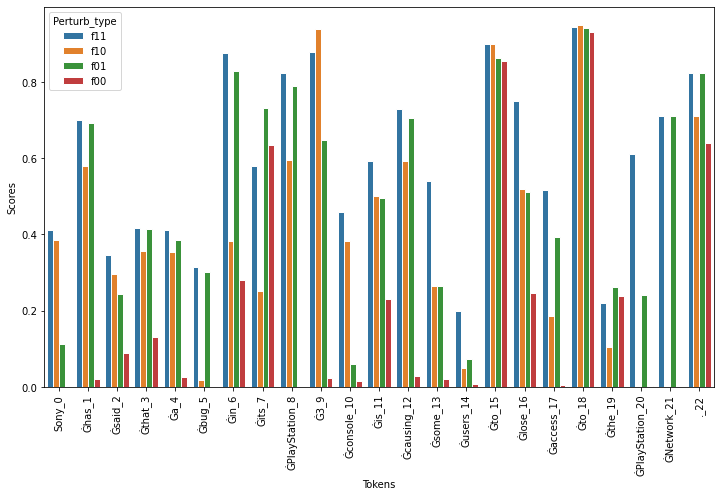


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.

 Summary (f10):  PlayStation 3 owners are being warned that their games may not be playable because of a fault in the operating system.

 Masked input (f01): Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads.

 Summary (f01): Sony's Xbox One console has been affected by a fault which has caused some games to stop being playable.

 Interaction Effect: [ 1.71152420e-01 -1.86302406e-01 -1.13932125e-01  2.40753942e-02
 -2.31957066e-02 -4.07330500e-02 -2.48653103e-01 -1.13884701e-01
 -3.65611400e-01 -1.30076620e-01 -2.51578362e-01  8.62608584e-02
 -5.35443220e-01 -1.48352293e-01 -2.37409318e-02 

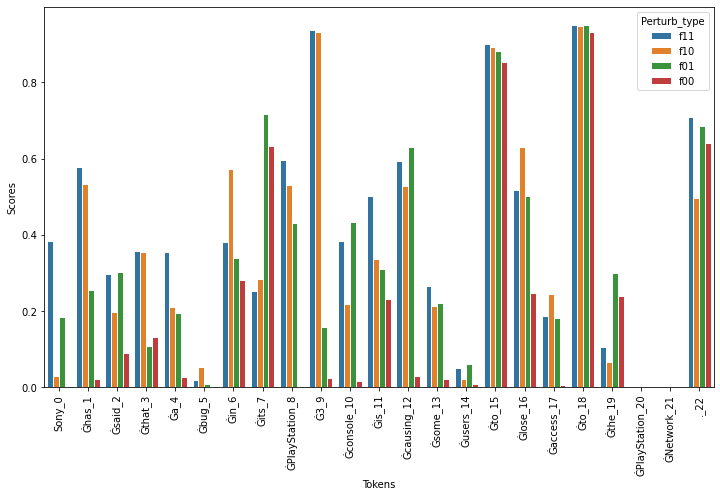


 Masked input (f10):  "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies,

 Summary (f10):  The PS3 games console has been put on hold until the end of the year because of "technical issues".

 Masked input (f01):  and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download software or visit online stores.


 Summary (f01): Sony has blamed a bug for problems with its PlayStation Network.

 Interaction Effect: [-0.07116488 -0.56386522 -0.12612306  0.01902478  0.25840294 -0.00863521
 -0.3900566  -0.06120705 -0.28191482 -0.23868543 -0.05800538  0.186

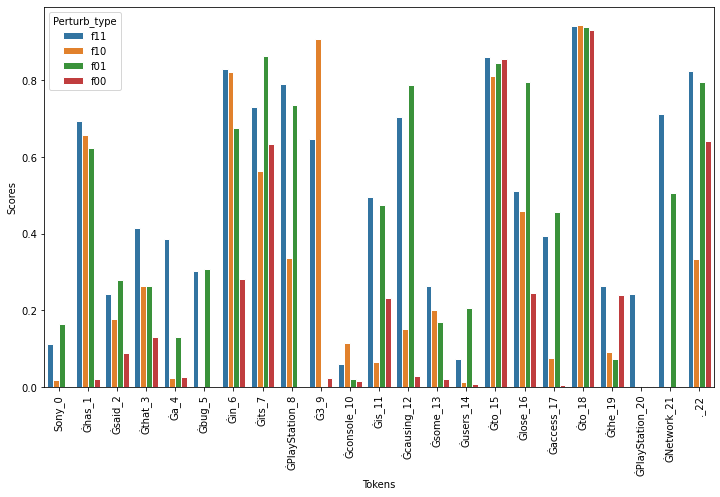


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.

 Summary (f10):  PlayStation 3 owners are being warned that their games may not be playable when they play online.

 Masked input (f01): The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.

 Summary (f01):  PlayStation 3 owners are being warned that their games consoles may be affected by a fault in the operating system.

 Interaction Effect: [-3.88164578e-02 -5.96492817e-01 -7.65837231e-03  4.80834087e-02
 -1.39429767e-01 -1.85046507e-02 -6.54934799e-02 -1.40309737e-01
 -4.24577779e-01 -8.57972821e-01 -8.86120232e-02  8.41547687e-02
 -3.57341291e-01 -1.79449786e-01 -1.62860790e-02  2.60225887e-02
 -3.62701331e-01 -7.83644926e-02 -1.97822068e-02  6.20674264e-02
 -2.17128507e-03  5.71008101e-04  4.21936467e-01]

 Main Effect: [ 2.96983322e-02  5.10766744e-01  1.08908434e-01  2.24172155e-01
  1.82148085e-01  5.3

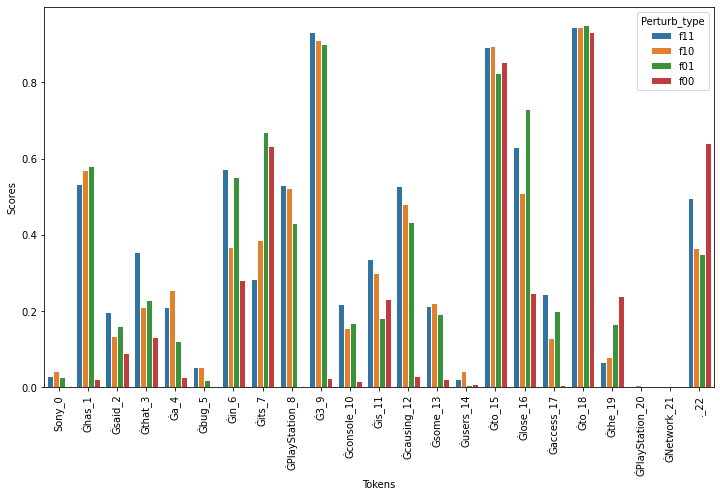


 Masked input (f10):  "In the meantime, if you have a model other than the new slim PS3,

 Summary (f10):  In the next few weeks, Sony will release a new version of the PlayStation 3.

 Masked input (f01):  we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies,

 Summary (f01):  The Xbox One games are being played on the PlayStation 3.

 Interaction Effect: [-0.00270478 -0.1599116   0.1302087  -0.19897099  0.02129489  0.00177205
 -0.18099274 -0.1465032  -0.01519749 -0.48694553 -0.09254775  0.13368104
 -0.03873276 -0.14190284 -0.01454173 -0.03548985  0.13461475  0.01027819
 -0.01419753 -0.05062981 -0.00799031  0.00052522  0.17704038]

 Main Effect: [ 1.82293011e-02  6.34437756e-01  8.93764017e-02  1.31275095e-01
 -4.42453565e-03  3.51710675e-03  5.41678759e-01 -7.02432939e-02
  3.35716257e-01  8.85599996e-01  9.73029387e-02 -1.64928094e-01
  1.21769537e-01  1.81070828e-01  6.01119377e-03 -4.36901032e-0

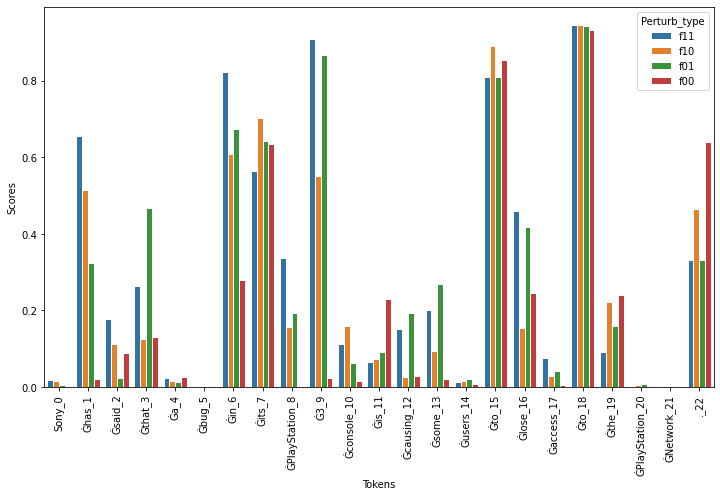


 Masked input (f10):  and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.

 Summary (f10):  PlayStation has blamed a "bug" for problems with the PlayStation Network.

 Masked input (f01): It allows users to play their friends at games like Fifa over the internet and also do things like download software or visit online stores.


 Summary (f01):  A new mobile phone app called FaceTime has been launched in the US.

 Interaction Effect: [ 0.04704817 -0.5796027   0.07942602  0.03219247  0.00420601 -0.06581411
 -0.05020876 -0.17944633 -0.04615905 -0.04423185 -0.03815214  0.06943513
 -0.028152   -0.06510865  0.04474299 -0.02930346 -0.23427874 -0.030576
 -0.01727383  0.20178959 -0.00182503  0.3726479  -0.05732824]

 Main Effect: [ 0.16480785  0.60083866  0.19069884  0.13243858  0.10460147  0.30774082
  

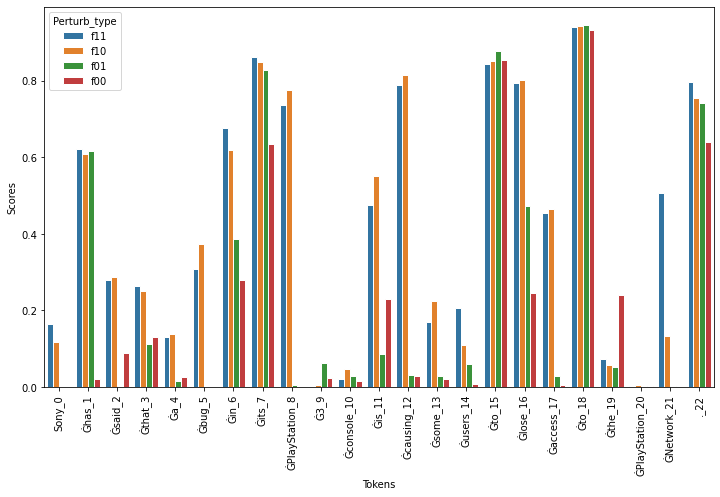


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3,

 Summary (f10):  PlayStation 3 owners are being warned about a fault in the game's operating system.

 Masked input (f01):  called the "Fat" model.

 Summary (f01):  A model of a woman with a thin waist has been developed in the United States.

 Interaction Effect: [-0.00364974  0.00393735  0.10320526  0.04661423 -0.02501601 -0.0138196
  0.32808616 -0.339828    0.1377917   0.48218557  0.03730488 -0.00744299
 -0.020291    0.0143497  -0.05050409 -0.00939713 -0.40533104 -0.41566383
 -0.02444178 -0.02681991 -0.00116707  0.00072801 -0.05825891]

 Main Effect: [ 4.12403562e-02  5.49245025e-01  4.54675085e-02  7.90551984e-02
  2.28022002e-01  5.37473057e-02  8.62022503e-02 -2.46253967e-01
  5.23195474e-01  8.88704830e-01  1.39033781e-01  6.88229722e-02
  4.51782178e-01  2.00413943e-01  3.24948387e-02  4.14453678e-02
  2.63636317e-01  1.22327405e-01  1.45329937e-02 -1.61798412e-01
  2.47861917

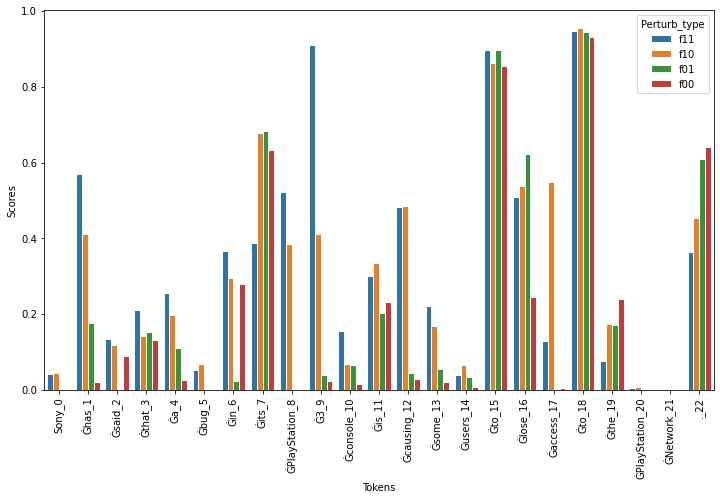


 Masked input (f10): The problem isn't affecting the newer PS

 Summary (f10):  The BBC has confirmed it is working to fix a fault in the PlayStation 4.

 Masked input (f01): 3 Slim systems that have been on sale since September last year.

 Summary (f01):  The BBC Sport website is continuing to offer BBC One's iPlayer and iPlayer services to customers across the UK.

 Interaction Effect: [ 0.01493464 -0.31369567  0.13345254  0.11176248  0.05879462  0.00562232
 -0.45104891 -0.20581119  0.20092029  0.46750836  0.12310237  0.06549695
 -0.08393673 -0.19684265 -0.12509709  0.0313172  -0.31340596  0.03279553
 -0.00230001 -0.40392379 -0.00789611  0.00064415 -0.11761513]

 Main Effect: [ 2.72744338e-02  5.58014536e-01  7.10992977e-02  9.70335480e-02
  9.35558499e-02  1.78084600e-02  2.70405966e-01  3.55237699e-02
  4.32129869e-01  8.79695765e-01  1.50840647e-01 -4.84509042e-02
  4.02500892e-01  1.71190282e-01 -2.96884569e-03 -2.98957654e-02
  4.84214129e-01  1.94436506e-01  2.05069466e-02 -7

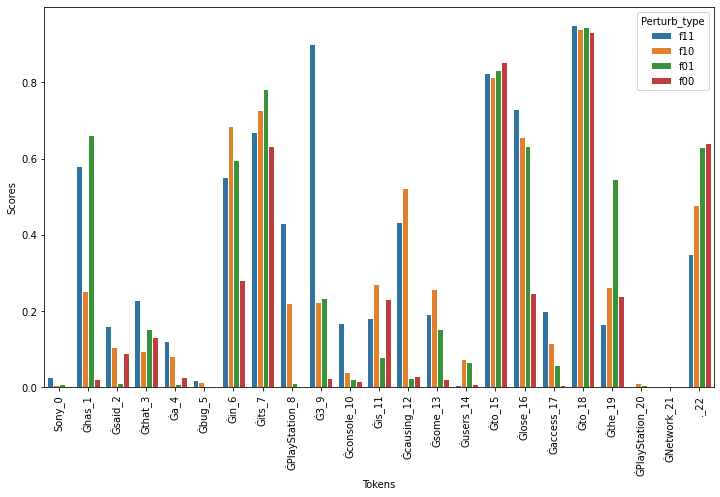


 Masked input (f10):  we advise that you do not use your PS3 system,

 Summary (f10): Sony has released a new video game that will be playable on the PlayStation 4.

 Masked input (f01):  as doing so may result in errors in some functionality, such as recording obtained trophies,

 Summary (f01): The BBC Sport website does not automatically recognise players who have won the Premier League.

 Interaction Effect: [-0.01430428 -0.45047315  0.06402207  0.02232473 -0.05286153 -0.01339594
 -0.16217928 -0.20633649  0.00819845  0.25172529 -0.03187666  0.0318199
 -0.02247054  0.0768781  -0.15981028 -0.03668324  0.02787428 -0.19713736
 -0.01775994  0.14133608 -0.00104713 -0.00273346 -0.11873182]

 Main Effect: [ 4.75576716e-03  3.02084548e-01 -6.44081372e-02  3.35420743e-01
 -1.41454203e-02  1.86083975e-03  3.94323684e-01  8.37940669e-03
  1.93784867e-01  8.45132432e-01  4.75645293e-02 -1.39894205e-01
  1.63155515e-01  2.48417192e-01  1.23090954e-02 -4.42403464e-02
  1.72112410e-01  3.65037891

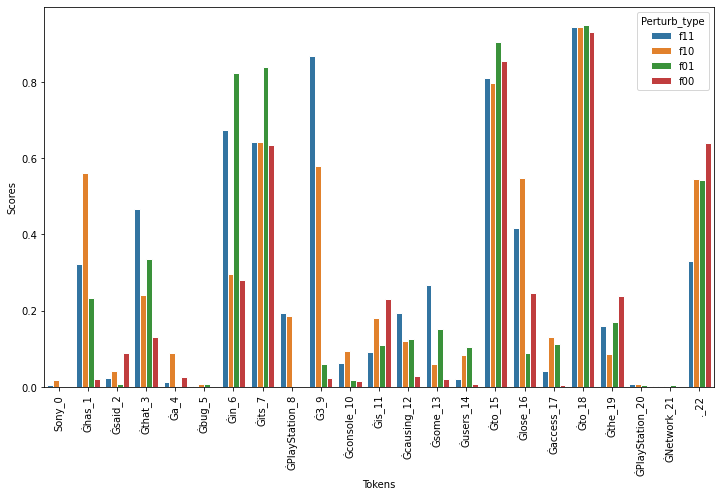


 Masked input (f10):  and not being able to restore certain data."We believe we have identified that this

 Summary (f10):  The BBC has confirmed that it is investigating a number of "technical issues" with its website.

 Masked input (f01):  problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.

 Summary (f01):  The PlayStation Network is experiencing problems with its operating system, the company has said.

 Interaction Effect: [ 0.03490186 -0.17769633 -0.12561541 -0.00329633 -0.00462338  0.31598815
 -0.06472836 -0.05667274 -0.09493446 -0.03369293 -0.03928444 -0.15044689
 -0.28618332  0.00338969 -0.00268353  0.08190856 -0.44466912 -0.32016455
  0.00303254 -0.01245127 -0.00209651  0.07998994  0.29790359]

 Main Effect: [ 0.1165446   0.58690033  0.19829523  0.12030217  0.11032564  0.37363182
  0.33941931  0.21455308  0.77694521 -0.01706508  0.02976375  0.31969252
  0.78531974  0.

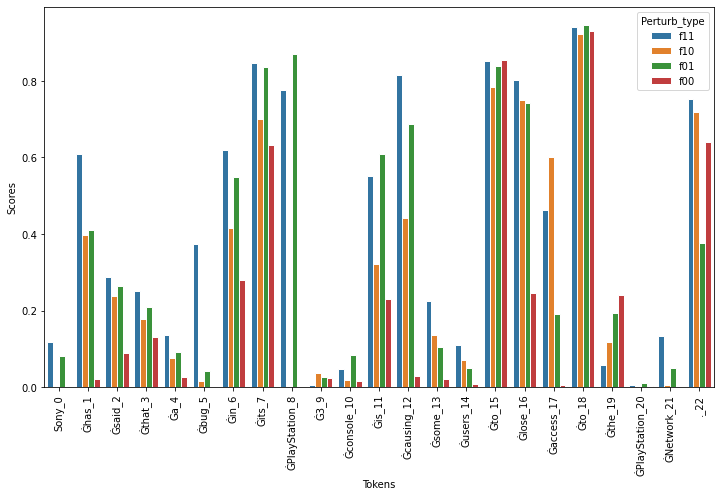


 Masked input (f10): 3 Slim systems that have been on sale

 Summary (f10):  The BBC News website looks at some of the best of the latest mobile phone technology.

 Masked input (f01):  since September last year.

 Summary (f01):  The BBC Sport website looks back at some of the most eye-catching stories of the past 12 months.

 Interaction Effect: [ 3.69148972e-03  2.20510246e-01  4.98782338e-02  3.69785247e-02
  4.07922501e-03  8.47009285e-05  2.97818396e-01 -2.12325980e-01
  4.62383626e-03  3.36139432e-02 -1.09582523e-01 -1.03922181e-01
 -8.72671575e-02 -3.17157912e-02  2.24251755e-02 -1.29942334e-02
  7.40756525e-02  1.27139743e-02 -2.28162031e-02  6.84826600e-02
 -4.09514658e-03  2.87130953e-04 -1.87266890e-03]

 Main Effect: [ 7.03674574e-03  6.40095987e-01 -7.83193826e-02  2.16704978e-02
 -1.91335658e-02 -8.64758806e-05  3.15447898e-01  1.48247822e-01
  1.00923355e-02  2.11181192e-01  3.87352367e-03 -1.53185122e-01
 -5.44388515e-03  1.31319903e-01  5.74812697e-02 -2.15860240e-02

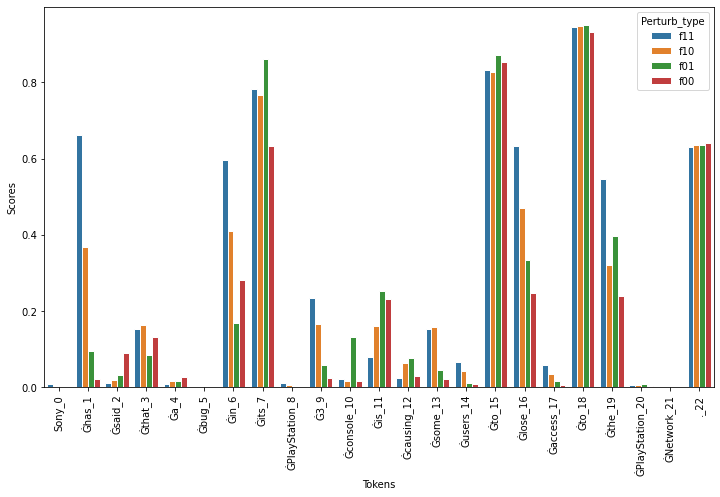


 Masked input (f10): Sony have also said they are aiming to have the problem fixed shortly but is advising

 Summary (f10): Sony has said it is working with Apple to fix a fault in its iPhone 7.

 Masked input (f01):  some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads.

 Summary (f01):  The BBC has said it is working to fix a fault in its online console that has caused it to stop working.

 Interaction Effect: [-0.06011459 -0.42818129 -0.10052494  0.06442066 -0.10825272 -0.04009854
 -0.64843157 -0.16381868  0.36139744  0.05618357 -0.24645006 -0.09843233
 -0.3231227  -0.14610278 -0.2041999   0.10897011 -0.12982864 -0.57199218
 -0.01673689  0.04868461  0.00197186 -0.00173032  0.25784868]

 Main Effect: [ 0.18356082  0.23228706  0.2122403  -0.02303319  0.1679787   0.00716751
  0.05835798  0.08390074  0.42962665  0.13546821  0.41747994  0.07847253
  0.60081327  0.20103959  0.05162448  0.02650267  0.25569

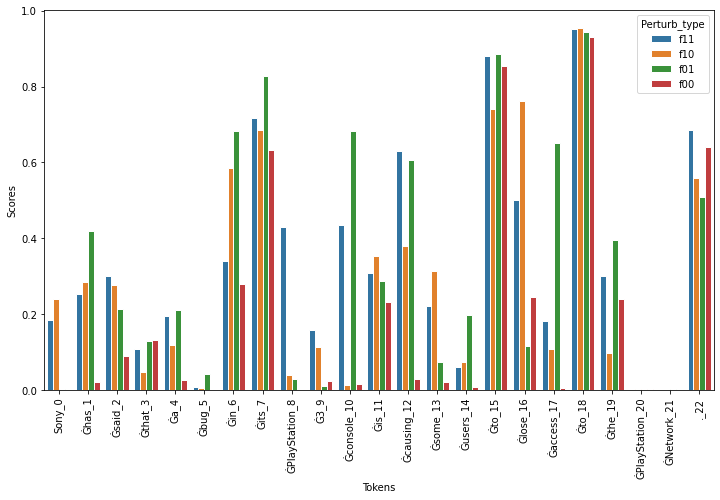


 Masked input (f10):  problem is being caused by a bug in the clock functionality incorporated in the system."

 Summary (f10):  The BBC has confirmed it is experiencing problems with its computer system.

 Masked input (f01): The PlayStation Network is used by millions of people around the world.

 Summary (f01):  The PlayStation Network is the world's most popular video game platform.

 Interaction Effect: [ 0.00068955 -0.21221192  0.14669415  0.00239354  0.08674046  0.02594313
 -0.47669998 -0.19846426  0.15856284 -0.09220076 -0.05023945  0.10386737
  0.00538073  0.06442273 -0.03098287  0.04784382 -0.14587554 -0.14841256
 -0.02107635 -0.01915263 -0.00927057 -0.09646227 -0.28466069]

 Main Effect: [ 0.08047315  0.38901466  0.17453711  0.0783839   0.06557678  0.04151061
  0.26932886  0.20352058  0.87039791  0.00346952  0.06700998  0.37846239
  0.65825275  0.08477687  0.04159901 -0.01468648  0.49625038  0.18392701
  0.01568084 -0.04663052  0.00586999  0.04809485 -0.26435269]

 f10 Effe

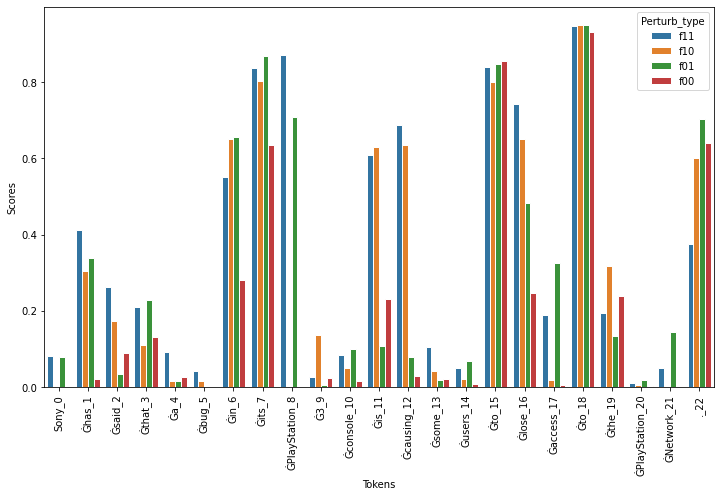


 Masked input (f10):  some users to avoid using their console for the time being."We hope to resolve

 Summary (f10):  The BBC has apologised for a fault in its online console that has caused problems with the operating system.

 Masked input (f01):  this problem within the next 24 hours," a statement reads.

 Summary (f01):  The Irish government says it will deal with a "major technical problem" with its computer system.

 Interaction Effect: [-1.85797699e-03 -2.55235806e-01 -8.06047852e-02  8.93001946e-02
  2.89696962e-02 -2.45975646e-02 -3.11021628e-01 -1.87244894e-01
 -1.22841571e-02 -4.33590867e-02 -1.87233861e-01  1.55446265e-02
 -1.38488605e-01 -7.51887905e-02 -7.06702154e-02  5.18190539e-02
 -1.53304653e-01 -3.30754420e-01 -1.08005129e-02 -3.89008425e-02
 -2.46516430e-03 -2.88765853e-04  2.32274833e-01]

 Main Effect: [ 0.0026738   0.3968109   0.1246607  -0.00245775  0.18392852  0.04083158
  0.40227763  0.19493093  0.02823286 -0.01236304  0.66774588  0.05572092
  0.57534717  0

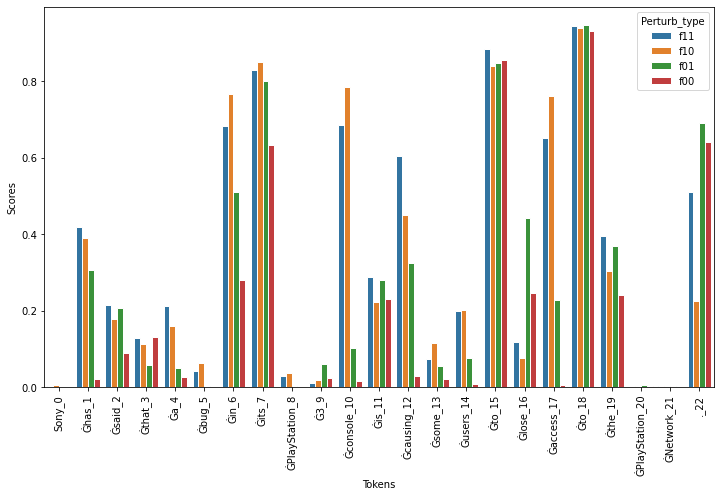


 Masked input (f10):  and not being able to restore certain data

 Summary (f10): Microsoft says it has fixed problems with its operating system.

 Masked input (f01): ."We believe we have identified that this

 Summary (f01):  The BBC has confirmed it is investigating a series of "suspicious incidents" in the Scottish Borders.

 Interaction Effect: [-1.78853925e-03 -1.13919070e-01  9.57701130e-02  4.00306085e-02
 -3.24267687e-02 -2.87748305e-03  2.29701669e-01 -2.75547354e-01
 -9.94999481e-05 -4.63739299e-02 -1.02049687e-01  4.75907647e-02
 -1.20926827e-02  1.92104697e-02 -3.87768482e-02 -1.50967667e-02
 -3.92494596e-02 -7.79389938e-02 -3.60157623e-02 -1.34471651e-01
 -5.00992204e-03  2.91976249e-04 -3.33215093e-03]

 Main Effect: [ 0.00116959  0.375582    0.14937354  0.04521461  0.04937224  0.01613306
  0.13481881  0.06770524  0.00148176  0.01315834  0.00203821  0.09167702
  0.41325032  0.11565129  0.06344134 -0.06998248  0.50392636  0.59398961
 -0.00826566 -0.1230134  -0.00298184  

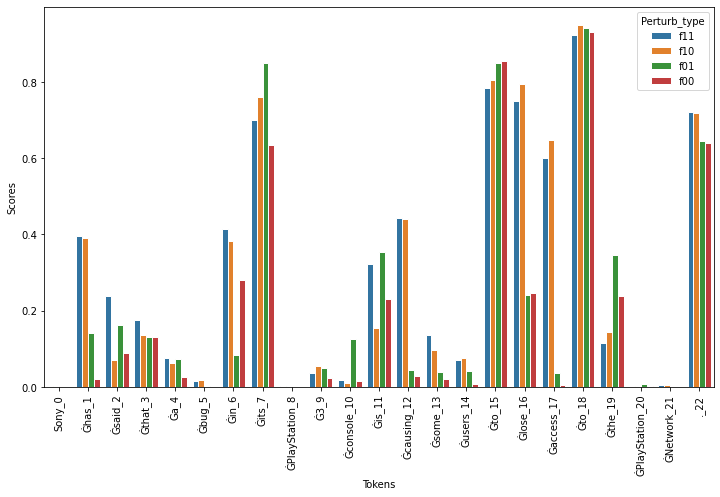


 Masked input (f10):  some users to avoid using their console for

 Summary (f10): Microsoft's operating system has been hit by problems with its operating system.

 Masked input (f01):  the time being."We hope to resolve

 Summary (f01):  "We are not in a crisis, we are not."

 Interaction Effect: [-0.00367769 -0.05069748  0.13718907 -0.06913879  0.13759394 -0.00543254
 -0.09573355 -0.20199768  0.0162447  -0.09360676  0.32533529 -0.065649
  0.11518032 -0.060465   -0.083293   -0.04345058  0.06854144  0.43059047
 -0.01917025  0.1201097  -0.00512739  0.00107454 -0.23456773]

 Main Effect: [ 4.16476548e-03  3.67349490e-01  8.75553203e-02 -1.81926155e-02
  1.33172790e-01  6.26736664e-02  4.84569622e-01  2.15989983e-01
  3.71286455e-02 -5.40215709e-03  7.69315707e-01 -8.61967414e-03
  4.18733700e-01  9.44585735e-02  1.91976911e-01 -1.43035028e-02
 -1.71068191e-01  7.54335794e-01  7.85243641e-03  6.50857331e-02
 -2.39945330e-03  7.44973416e-04 -4.14265798e-01]

 f10 Effect: [0.00770024 0.34

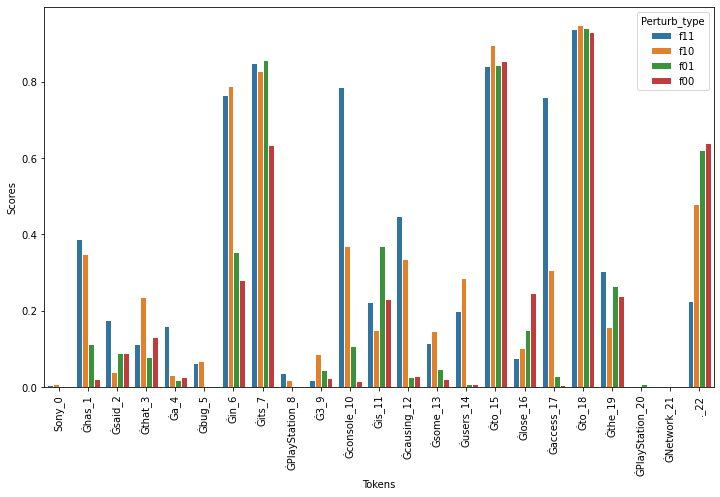


 Masked input (f10): The PlayStation Network is used by millions of

 Summary (f10):  The PlayStation is the world's most popular video game.

 Masked input (f01):  people around the world.

 Summary (f01):  A look back at some of the best stories of the year.

 Interaction Effect: [ 2.95314378e-02  8.87132305e-02  3.69678446e-02 -9.97373537e-03
 -1.73386333e-02 -9.59900688e-05  3.04011026e-01 -1.67191423e-01
  1.40449506e-01 -6.50446236e-02 -2.49502229e-02 -1.55472451e-01
 -5.24084252e-02 -1.35890453e-02 -1.48377671e-02  2.43644242e-02
  1.34287870e-01  1.59645800e-02 -1.54961784e-02 -1.46692052e-01
  1.89541996e-03  1.18375254e-01  1.05655091e-01]

 Main Effect: [ 7.88212291e-02  3.17751596e-01 -5.53299948e-02  9.74655634e-02
 -1.08179990e-02  4.68840641e-05  3.75190274e-01  2.33447108e-01
  7.08133997e-01 -1.82599202e-02  8.25863359e-02 -1.24249446e-01
  4.88408112e-02 -1.58076306e-03  6.09936938e-02 -6.65337971e-03
  2.37107889e-01  3.19584523e-01  1.79261135e-02 -1.05899038e-01
 

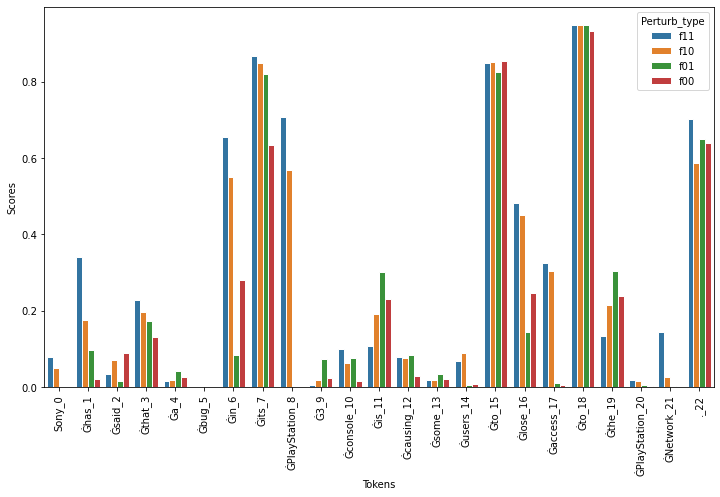


 Masked input (f10):  and not being able

 Summary (f10):  A woman has spoken of her frustration at not being able to tell the truth about her life.

 Masked input (f01):  to restore certain data

 Summary (f01): The BBC has restored access to some of its online services, including the BBC News website and BBC iPlayer.

 Interaction Effect: [ 0.00081277 -0.15540464  0.06389307  0.020662   -0.00572937  0.01004439
  0.06748397  0.53418064 -0.00256938 -0.06181168 -0.03723408  0.06527025
  0.24369593 -0.00247591  0.03842818 -0.01409708  0.08188218  0.03454021
  0.00190741 -0.16619785 -0.0010737   0.00224251  0.08626882]

 Main Effect: [ 0.00281538  0.3684061  -0.01926747  0.00560104  0.03506402  0.01749965
  0.10200035  0.12790996  0.00114406  0.03220408 -0.0045079  -0.07755651
  0.41026984  0.07786788  0.06855241 -0.04871153  0.54827769  0.64175508
  0.01855491 -0.09506672 -0.00223501  0.00270246  0.07871883]

 f10 Effect: [8.20109597e-05 3.60396671e-02 6.58263709e-02 1.58733552e-01
 3.8

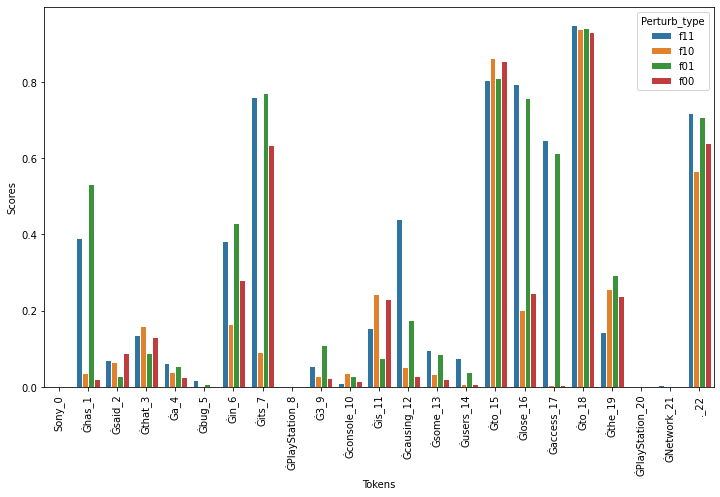


 Masked input (f10):  to restore

 Summary (f10): Power has been restored to some parts of the UK after a year of power cuts.

 Masked input (f01):  certain data

 Summary (f01): Data released by the European Commission on Tuesday shows that the European Union has set a record for the number of countries with a combined population of more than 100 million.

 Interaction Effect: [ 1.42891443e-03  2.28287502e-01 -2.63042363e-02  3.84797642e-02
  1.59014244e-02  5.74517151e-03  6.38873056e-02 -2.36821530e-01
  2.23984018e-04 -5.23332101e-02 -8.45490172e-02 -5.68562501e-02
  4.28289637e-02 -8.80153245e-02 -7.17755955e-02  5.11028878e-02
 -3.03589389e-01  4.36788958e-01  2.66697328e-03  1.35398054e-01
 -3.89161936e-03 -3.68475700e-03  2.69154512e-01]

 Main Effect: [ 1.93694965e-03  5.09434029e-01 -5.98819315e-02 -4.22084237e-02
  2.92701357e-02  7.33871915e-03  1.49798170e-01  1.36211037e-01
  3.72895725e-03  8.63753285e-02  1.25629671e-02 -1.55083837e-01
  1.44975287e-01  6.62894769e-02 

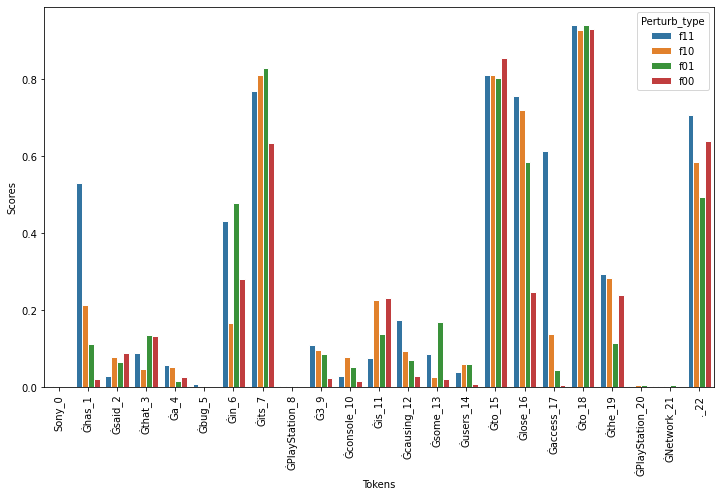


 Masked input (f10):  problem is being caused by a bug in

 Summary (f10):  The BBC has said it is working to fix problems with its computer system.

 Masked input (f01):  the clock functionality incorporated in the system."

 Summary (f01):  The BBC has confirmed it is working on a new version of the BBC iPlayer.

 Interaction Effect: [-0.00500466 -0.48425263  0.06090763  0.03198267  0.00649576 -0.0850611
 -0.55401964 -0.12307049 -0.00230264 -0.08681088 -0.03519544  0.11884507
  0.08562877 -0.05912774 -0.04579008  0.07067422 -0.03950974 -0.10074366
 -0.01348102  0.13500755 -0.00106299 -0.00126269  0.2194446 ]

 Main Effect: [ 9.62372178e-04  2.83474990e-01  8.31729453e-02 -2.14752066e-02
 -1.03456810e-02  1.55205999e-02  3.70838572e-01  1.68537732e-01
  3.70106520e-03  1.13930201e-01  3.46631006e-02  3.98844472e-01
  6.04031210e-01  2.19349069e-02  1.15881842e-02 -5.58769214e-02
  4.05018036e-01  1.27550509e-02  1.88310812e-02  7.84211497e-02
  1.30165235e-03  4.89557712e-04 -4.10680

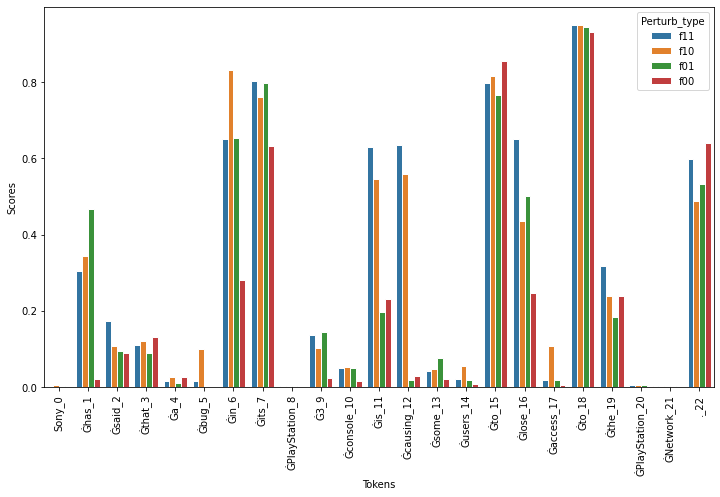


 Masked input (f10): It allows users to play their friends at games like Fifa over the internet and also do things like download software or visit online stores.

 Summary (f10):  A new mobile phone app called FaceTime has been launched in the US.

 Masked input (f01): 


 Summary (f01): Questions are still being asked on social media about the impact of the EU referendum.

 Interaction Effect: [-1.79121229e-05 -1.17181963e-02  1.87427194e-04  4.86836684e-04
 -4.00268108e-04  2.04750191e-05  5.41856867e-02 -8.84931255e-03
 -4.35762479e-04  2.01807147e-04 -3.43066771e-04  4.07945902e-03
  6.09237158e-03  1.41961633e-03 -1.00953415e-02 -4.15210587e-03
 -7.44976627e-03 -1.40668933e-03  7.48491775e-05  1.85894113e-03
 -2.85588238e-04 -1.54846546e-04  2.03410591e-02]

 Main Effect: [ 1.21508232e-03  5.93541029e-01 -8.70224166e-02 -2.00560614e-02
 -9.93018093e-03 -7.68914134e-05  1.06428071e-01  1.93853074e-01
  5.16273194e-03  3.93139037e-02  1.19986888e-02 -1.45982102e-01
  1.06154537e-03

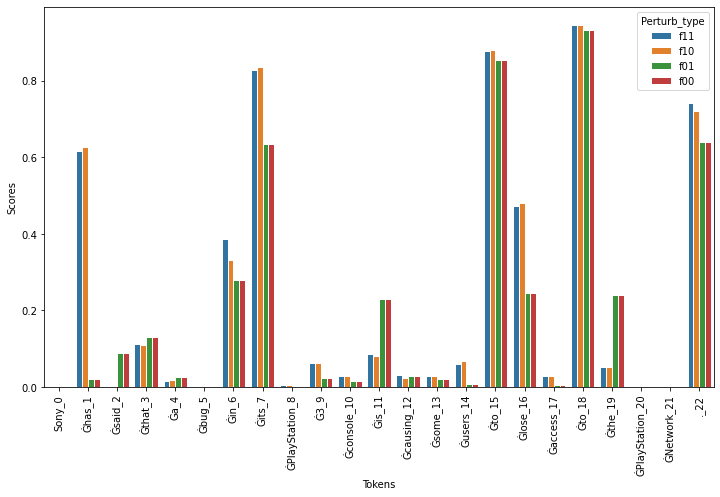


 Masked input (f10): It allows users to play their friends at games like Fifa over the internet and also

 Summary (f10): Facebook has launched a new social network called Facebook Live.

 Masked input (f01):  do things like download software or visit online stores.

 Summary (f01): Online shopping is one of the most common ways that people can get online.

 Interaction Effect: [-8.62169169e-04 -2.61675344e-01  7.17555832e-02 -2.84674117e-01
 -6.22396854e-03 -1.14461050e-04  3.32111741e-02  5.08017464e-01
 -1.11824777e-03 -4.42466997e-02 -1.63717924e-02  7.08181230e-03
 -2.02846934e-02 -3.24615238e-02 -1.29339330e-01  7.49929653e-03
 -1.70522718e-01 -1.42922098e-01 -8.76337182e-03  1.57264734e-01
  2.41642780e-03 -6.03894081e-04  1.07802890e-01]

 Main Effect: [ 1.23299444e-03  6.05259225e-01 -8.72098438e-02 -2.05428981e-02
 -9.52991282e-03 -9.73664325e-05  5.22423845e-02  2.02702387e-01
  5.59849442e-03  3.91120965e-02  1.23417556e-02 -1.50061561e-01
 -5.03082622e-03  8.16503465e-03 

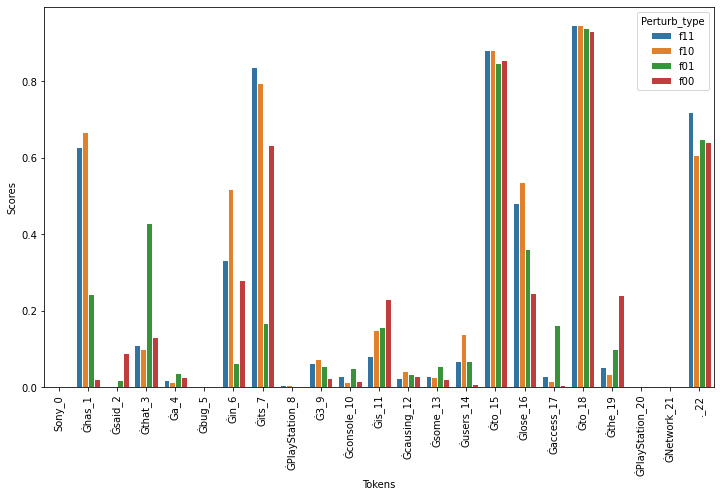


 Masked input (f10): The PlayStation Network is

 Summary (f10):  The PlayStation Network is the world's largest online video game.

 Masked input (f01):  used by millions of

 Summary (f01):  The BBC News website looks back at some of the most popular news stories of the year.

 Interaction Effect: [ 0.03530592 -0.1803065   0.11480561 -0.17081635 -0.0266069  -0.00270106
  0.05000058 -0.04599945  0.04522278 -0.09689651 -0.04487393 -0.02356064
 -0.01352975 -0.02352555 -0.24182319  0.02169495 -0.2038077  -0.46877629
 -0.00670731 -0.05506935 -0.06828263 -0.00090983 -0.06458434]

 Main Effect: [ 4.92806829e-02  1.53702268e-01 -1.80000919e-02  6.59112871e-02
 -9.10077708e-03 -3.16305427e-06  2.68464372e-01  2.14140978e-01
  5.67655837e-01 -5.35410479e-03  4.67996455e-02 -3.93113844e-02
  4.72879514e-02 -1.55692701e-03  8.01282578e-02 -1.88301294e-03
  2.05729471e-01  2.98534428e-01  1.72699874e-02 -2.46552033e-02
  1.10596959e-02  2.56231886e-02 -5.24718184e-02]

 f10 Effect: [1.30489500e-

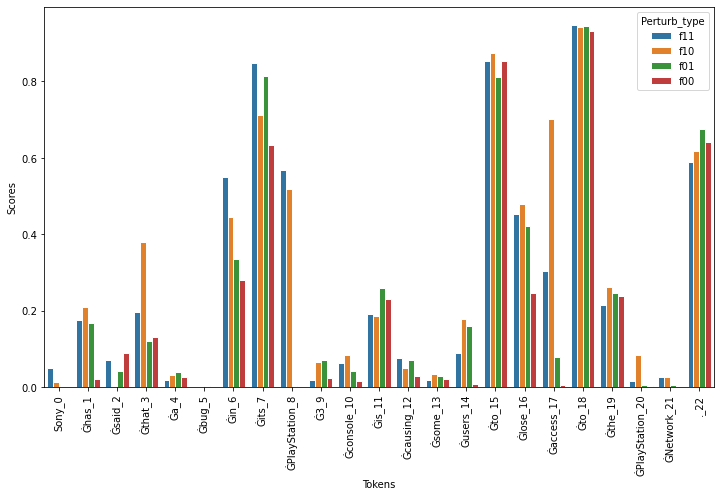


 Masked input (f10):  we advise that you do not use your

 Summary (f10): BBC Sport takes a look at some of the best news stories from the BBC Sport website.

 Masked input (f01):  PS3 system,

 Summary (f01):  PlayStation 3 is set to be released in the US this summer.

 Interaction Effect: [-0.00389253  0.04048982  0.05740585  0.00600792  0.07363705  0.00550177
 -0.01052222 -0.02929926 -0.05952564 -0.07163214 -0.11842799 -0.0163494
  0.01560746 -0.06102597 -0.16212087 -0.00489805 -0.09801759  0.00726475
 -0.00855763  0.07793663 -0.01101237 -0.00247367  0.01278307]

 Main Effect: [ 1.78418768e-02  5.40420396e-01 -4.68171047e-02  1.09262486e-01
  6.22385099e-02  8.50887646e-03  1.43787237e-02  8.57295713e-03
  1.85117771e-01  5.56376495e-01  7.76531463e-02 -5.11057984e-02
  9.03791869e-02  3.90551350e-02  7.66688413e-02 -5.73060747e-02
  3.01708867e-01  1.26310002e-01  1.16256374e-02 -1.52999636e-01
  4.15667188e-03  1.32375306e-04 -9.40146800e-02]

 f10 Effect: [0.00134261 0.25673778 

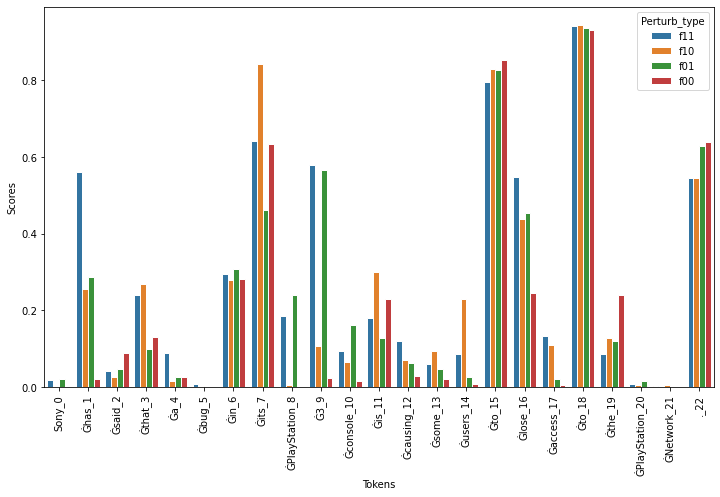

Partition explainer: 2it [00:59, 29.91s/it]                                                                            


In [11]:
shap_values = explainer(dataset['document'][0:1],model_kwargs=f_kwargs)

In [12]:
shap.plots.text(shap_values[0])

,,The,problem,is,affecting,people,using,the,older,versions,of,the,PlayStation,3,",",called,the,"""",Fat,"""",model,.,The,problem,isn,'t,affecting,the,newer,PS,3,Slim,systems,that,have,been,on,sale,since,September,last,year,.,Sony,have,also,said,they,are,aiming,to,have,the,problem,fixed,shortly,but,is,advising,some,users,to,avoid,using,their,console,for,the,time,being,".""",We,hope,to,resolve,this,problem,within,the,next,24,hours,",""",a,statement,reads,.,"""",In,the,meantime,",",if,you,have,a,model,other,than,the,new,slim,PS,3,",",we,advise,that,you,do,not,use,your,PS,3,system,",",as,doing,so,may,result,in,errors,in,some,functionality,",",such,as,recording,obtained,trophies,",",and,not,being,able,to,restore,certain,data,".""",We,believe,we,have,identified,that,this,problem,is,being,caused,by,a,bug,in,the,clock,functionality,incorporated,in,the,system,".""",The,PlayStation,Network,is,used,by,millions,of,people,around,the,world,.,It,allows,users,to,play,their,friends,at,games,like,Fifa,over,the,internet,and,also,do,things,like,download,software,or,visit,online,stores,.,Ċ,
Sony,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,0.003,0.003,0.003,0.003,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,0.0,0.0,0.0,0.0,0.001,0.001,0.001,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.01,0.01,0.007,0.007,0.007,0.007,0.003,0.003,0.003,0.003,0.003,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
has,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.004,0.004,0.004,0.004,0.004,0.004,0.004,-0.005,-0.005,-0.005,-0.005,-0.005,-0.005,-0.005,-0.005,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,-0.002,-0.002,-0.002,-0.002,-0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,-0.015,-0.015,-0.015,-0.015,-0.015,-0.015,-0.015,-0.015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.043,0.043,0.043,0.043,-0.014,-0.014,-0.014,-0.014,-0.014,-0.014,-0.014,-0.014,-0.014,-0.014,-0.014,-0.014,-0.014,-0.014,-0.014,-0.014,-0.014,-0.042,-0.042,-0.042,-0.042,0.107,0.107,0.056,0.056,-0.011,-0.011,-0.011,-0.011,-0.011,-0.011,-0.011,-0.011,-0.016,-0.016,-0.016,-0.016,-0.016,-0.016,-0.016,-0.016,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,0.005,0.005,0.005,0.005,-0.006,-0.006,-0.006,-0.006,-0.005,-0.005,-0.005,-0.005,-0.005,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,-0.004,-0.004,-0.004,-0.004,-0.004,-0.004,-0.004,-0.004,-0.004,-0.004,-0.016,-0.016
said,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.003,-0.003,-0.003,-0.003,-0.003,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,-0.005,-0.005,-0.005,-0.005,-0.005,-0.005,-0.005,-0.005,0.002,0.002,0.002,0.002,0.002,0.002,0.00